<a href="https://colab.research.google.com/github/IvaroEkel/AI-Spielplatz/blob/main/Tutorials/Computer_Vision/01_Getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Computer Vision 👀
Also known as Object Detection, this is an area of computer science that can help us detect objects. On top of this, we can also classify these detections and label them.

Think of it as an intelligent camera that knows what it's looking at: wether it's a cat, a tree, a bus, a car, etc. This process of finding objects and knowing what they are might be trivial for you, but your computer behaves like a baby: you have to teach it what an apple looks like and that its name is apple.

For now, you won't need any fancy knowledge, we can just dive in and try to detect things! Below you will see some code that you can just run to see some images and what has been detected.

In the repository there is a folder with example images you can use but feel free to upload your own images and test how well objects can be detected!

## Use a pre-trained model to perform object detection
Once you are sure your camera is working well, we can download a pre-trained model to start performing detections!

- But, what is a pre-trained model? ---> A pre-trained model is a model that has been trained on detecting some types of images already (in most cases, models are trained to detect common, everyday objects, which can be found in the [COCO database](https://cocodataset.org/#home)). Long story short, **a pre-trained model is ready to download and use to detect common objects.**

First things first, run the cell below to install all the necessary packages and import the libraries that we will need.

Cloning into 'AI-Spielplatz'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 22 (delta 0), reused 15 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), done.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
Receiving objects: 100% (5/5), 9.28 KiB | 9.28 MiB/s, done.
remote: Total 5 (delta 0), reused 2 (delta 0), pack-reused 0 (from 0)
/content/AI-Spielplatz
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 776.81 KiB | 6.37 MiB/s, done.
Processing 2088610709_b785aee3b9_z.jpg...


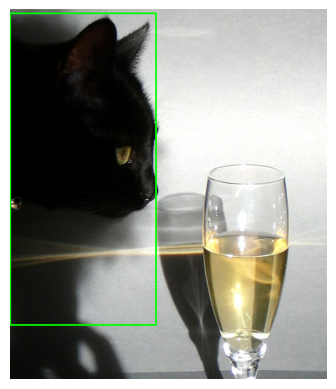

Processing 8095785980_7b1513874f_z.jpg...


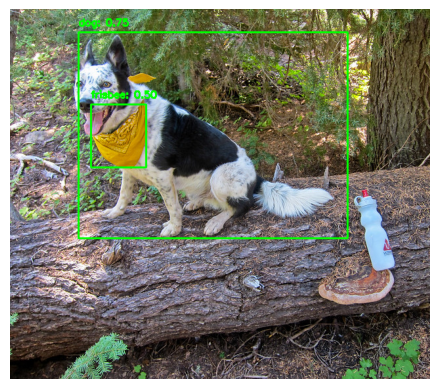

Processing 5545319403_b47cf7e009_z.jpg...


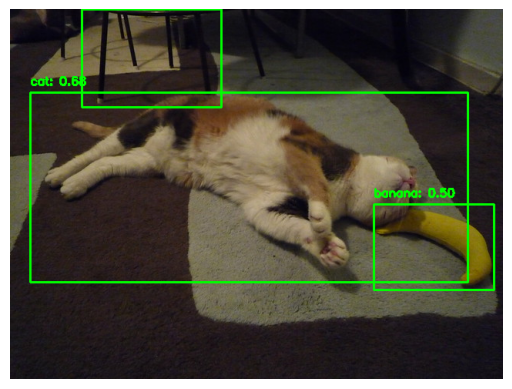

Processing 2352479949_c499627c58_z.jpg...


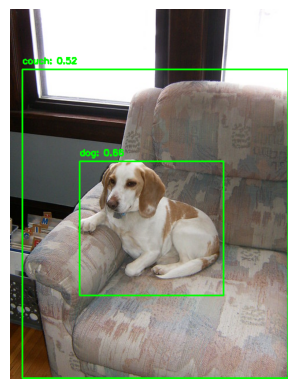

Processing 8702818172_05105ccf66_z.jpg...


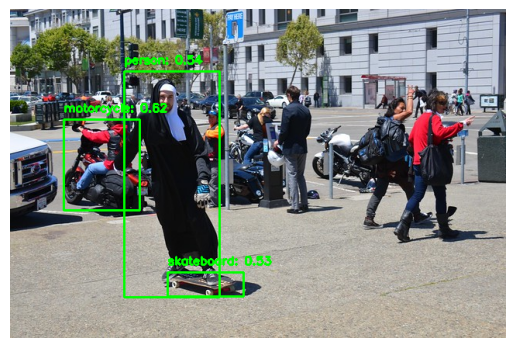

Processing 5543551607_235849bff3_z.jpg...


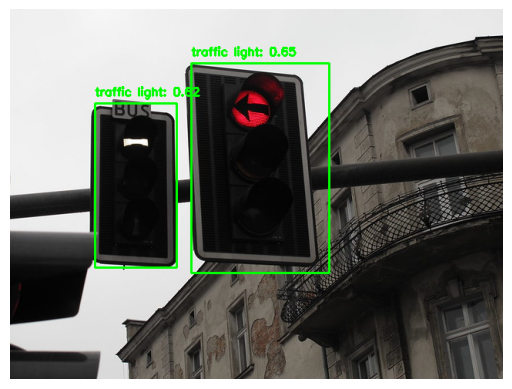

Processing 6926310497_2674568013_z.jpg...


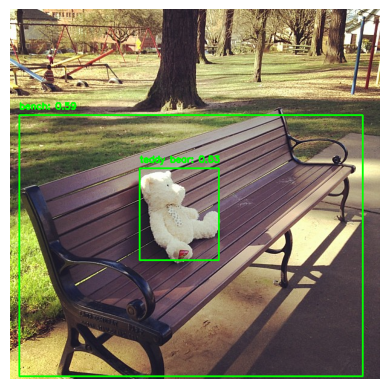

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import urllib.request
import tarfile
import matplotlib.pyplot as plt

# Download and extract the model
MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
MODEL_TAR = f"{MODEL_NAME}.tar.gz"
MODEL_URL = f"http://download.tensorflow.org/models/object_detection/tf2/20200711/{MODEL_TAR}"

if not os.path.exists(MODEL_TAR):
    urllib.request.urlretrieve(MODEL_URL, MODEL_TAR)

if not os.path.exists(MODEL_NAME):
    with tarfile.open(MODEL_TAR) as tar:
        tar.extractall()

# Load the model and labels from the COCO dataset
model = tf.saved_model.load(f"{MODEL_NAME}/saved_model")
LABELS_URL = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"
LABELS_FILE = "mscoco_label_map.pbtxt"

if not os.path.exists(LABELS_FILE):
    urllib.request.urlretrieve(LABELS_URL, LABELS_FILE)

def load_labels(path):
    category_index = {}
    with open(path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "id:" in line:
                id = int(line.split(":")[1].strip())
                name = lines[lines.index(line) + 1].split(":")[1].strip().replace('"', "")
                category_index[id] = name
    return category_index

category_index = load_labels(LABELS_FILE)

# Run object detection on a single image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(image_rgb)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # Get boxes, scores, and classes
    num_detections = int(detections.pop("num_detections"))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

    # Draw boxes on the image
    for i in range(num_detections):
        confidence = detections["detection_scores"][i]
        if confidence > 0.5:  # Confidence threshold
            box = detections["detection_boxes"][i]
            class_id = detections["detection_classes"][i]
            label = category_index.get(class_id, "Unknown")
            h, w, _ = image.shape
            y1, x1, y2, x2 = int(box[0] * h), int(box[1] * w), int(box[2] * h), int(box[3] * w)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Run detection on all images in the folder. Here we are cloning the folder Images from the repository of the workshop, but feel free to create your directory with your images.
# To do so, just change the IMAGE_FOLDER address to the address of the folder that has the images you want to test on.

!git clone --depth 1 --filter=blob:none --sparse https://github.com/IvaroEkel/AI-Spielplatz.git
%cd AI-Spielplatz
!git sparse-checkout init --cone
!git sparse-checkout set Data/Images

IMAGE_FOLDER = "Data/Images"                                    # Change this to your image folder (if necessary)

for filename in os.listdir(IMAGE_FOLDER):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        print(f"Processing {filename}...")
        detect_objects(os.path.join(IMAGE_FOLDER, filename))

###❓ What am I looking at?

You have performed your first detection with a model! Before starting with live object detection, it is important that you know some concepts of what you see in the images:
- **Bounding boxes:** the green boxes that you see around the cat, the dog or the person are called bounding boxes. The model predicts that the object we are detecting should be inside this box. Sometimes these boxes are not perfect, but we want to enclose the object as accurately as possible.
-**Labels:** you can see that on top of the bounding boxes there are some words: dog, skateboard, traffic light, etc. That is the prediction of what the model thinks what is this object. If you use this model with not-so-common objects (for example, cell images or lab equipment) it will try to match some type of label to the objects but mistakenly. This means that the model will tell you there is a chair where the mithochondria is, for example.
-**Confidence threshold:** when a model performs a detection, it is not always 100% sure the detection is correct. If your detection says something like: `couch 0.62`, this means the model is 62% confident that that is a couch, but it could be something else! The confidence threshold is a limit that we impose so that we only see detections that are more or less confident (i.e. depending on how accurate you want the detections to be). In the example that we ran above, you can check that the confidence threshold was set to 50%. Feel free to change its value and see how your detections change if you become more or less strict.

Another important piece of information is **metrics**, which will allow you to quantify "how good" or "bad" an object detection model is. I will not go into a detailed explanation about it, but [this Github repo of Rafael Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics) makes a great explanation of the most important metrics you should know about.

💡 Get creative and test the capabilities of your Object Detection model: is there any object it can't detect? is there any problem with small or big objects?

😮 You can also change the Object Detection model (i.e. the base of what makes the detection) if you want to see how other models perform.